# Challenge 2: Freezing Fritz

Freezing Fritz, is a pretty cool guy. He has one problem, though. In his house, it is quite often too cold or to hot during the night. Then he has to get up and open or close his windows or turn on the heat. Needless to say, he would like to avoid this. 

However, his flat has three doors that he can keep open or closed, it has four radiators, and four windows. It seems like there are endless possibilities of prepping the flat for whatever temperature the night will have. 

Fritz, does not want to play his luck any longer and decided to get active. He recorded the temperature outside and inside of his bedroom for the last year. Now he would like to find an prediction that, given the outside temperature, as well as a certain configuration of his flat, tells him how cold or warm his bedroom will become.

Can you help Freezing Fritz to find blissful sleep?

## Data Analysis

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.rcdefaults()
plt.rc("figure", figsize=(11.2, 6.3))
sns.set_theme(context = "notebook", style = "whitegrid", palette = "deep")

random_state = np.random.RandomState(0)

In [3]:
original_df = pd.read_csv("data_train_Temperature.csv")
original_df

,Window 1,Window 2,Window 3,Window 4,Heat Control 1,Heat Control 2,Heat Control 3,Heat Control 4,Door 1,Door 2,Door 3,Temperature Outside,Temperature Bed
0,0.0,0.0,1.0,1.0,0.0,5.0,1.0,1.0,0.0,1.0,1.0,8.232086,17.077426
1,0.0,0.0,1.0,1.0,1.0,4.0,1.0,3.0,1.0,1.0,1.0,5.935949,16.413221
2,1.0,1.0,1.0,0.0,1.0,5.0,5.0,3.0,0.0,0.0,1.0,10.550271,23.228559
3,0.0,1.0,1.0,0.0,4.0,3.0,3.0,3.0,1.0,0.0,0.0,2.591696,16.224344
4,1.0,0.0,0.0,1.0,2.0,1.0,4.0,0.0,1.0,1.0,1.0,18.516631,21.047208
...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,0.0,1.0,0.0,0.0,3.0,5.0,5.0,5.0,0.0,0.0,0.0,3.049163,26.011447
726,0.0,0.0,0.0,0.0,5.0,1.0,2.0,0.0,1.0,1.0,1.0,14.723168,25.502695
727,0.0,1.0,1.0,1.0,5.0,5.0,3.0,5.0,0.0,1.0,1.0,7.907167,19.478236
728,1.0,1.0,1.0,1.0,4.0,5.0,2.0,2.0,0.0,1.0,0.0,20.811523,22.482037


In [3]:
original_df.describe()

,Window 1,Window 2,Window 3,Window 4,Heat Control 1,Heat Control 2,Heat Control 3,Heat Control 4,Door 1,Door 2,Door 3,Temperature Outside,Temperature Bed
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,0.478082,0.473973,0.473973,0.502740,2.450685,2.561644,2.515068,2.416438,0.475342,0.471233,0.513699,8.211303,19.624089
std,0.499862,0.499664,0.499664,0.500335,1.735107,1.710825,1.734953,1.695391,0.499734,0.499514,0.500155,7.857266,3.915569
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.945738,9.246765
25%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.377688,16.473373
50%,0.000000,0.000000,0.000000,1.000000,2.000000,3.000000,3.000000,2.000000,0.000000,0.000000,1.000000,7.660876,20.289835
75%,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000,4.000000,4.000000,1.000000,1.000000,1.000000,15.096424,22.714459
max,1.000000,1.000000,1.000000,1.000000,5.000000,5.000000,5.000000,5.000000,1.000000,1.000000,1.000000,21.982949,28.306661


We use the correlation matrix again to see how each of the parameters of the problem affect the temperature in the bedroom. We also look at how the trade-off between outside and inside temperature is affected by some of the parameters.

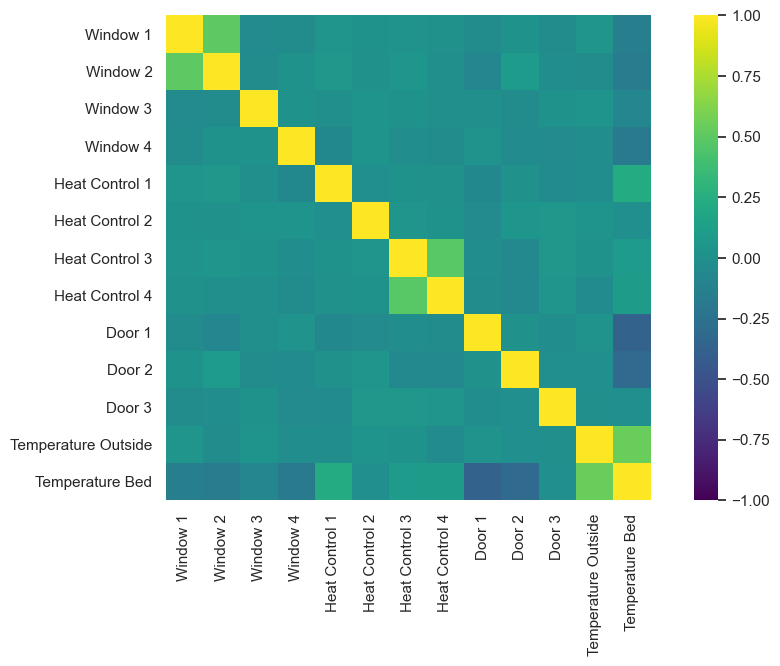

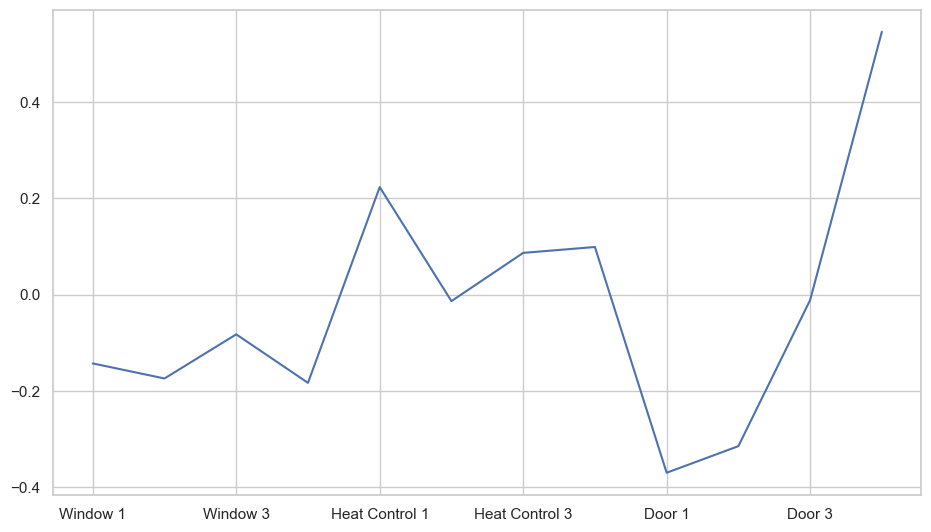

In [30]:
corr_matrix = original_df.corr()

sns.heatmap(corr_matrix, vmin = -1, vmax = 1, cmap = "viridis", annot = False, square = True)
plt.show()

corr_matrix["Temperature Bed"][:-1].plot()
plt.show()

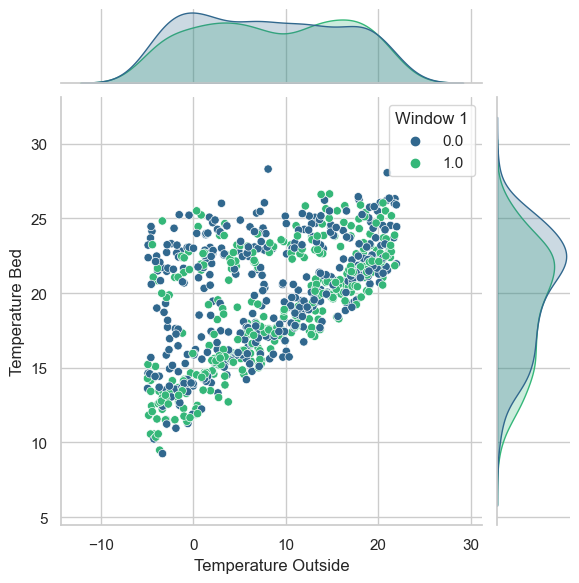

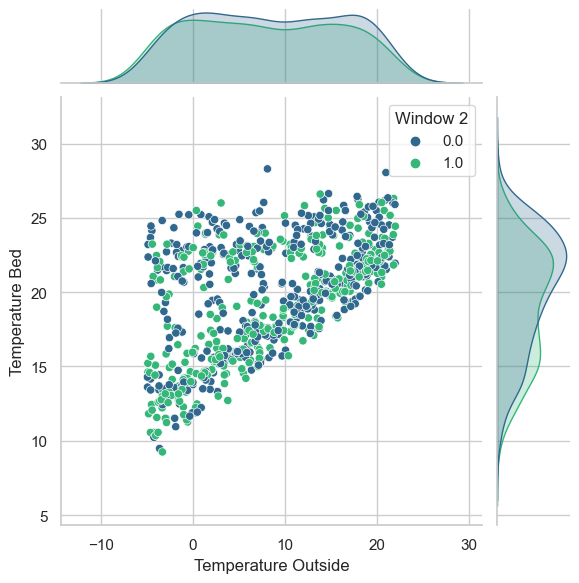

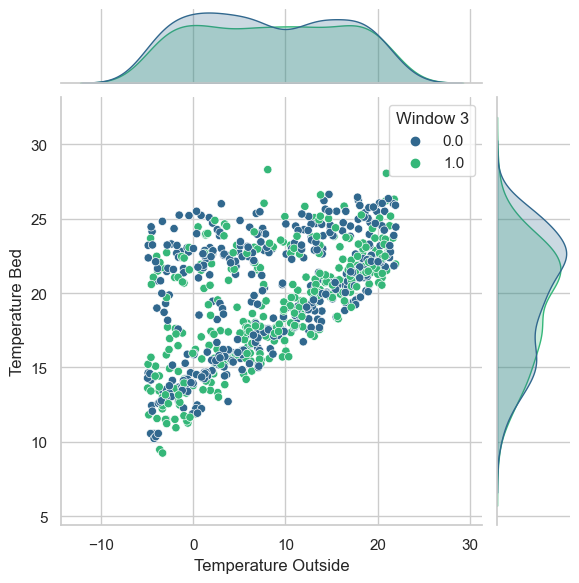

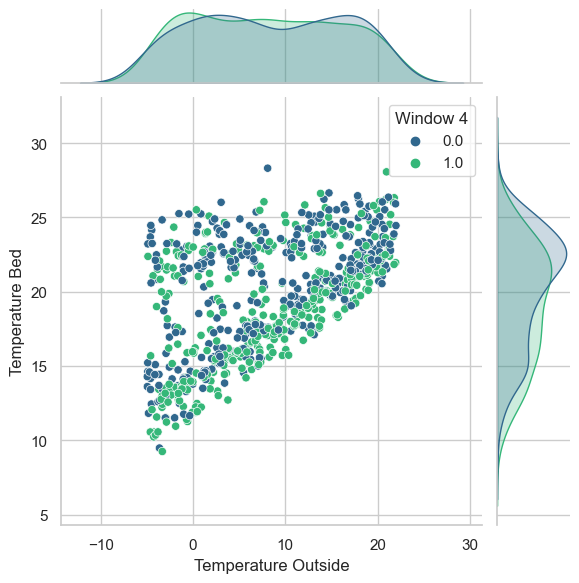

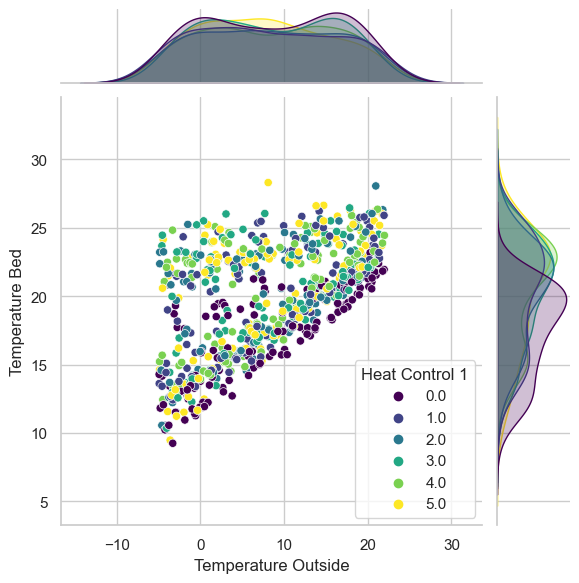

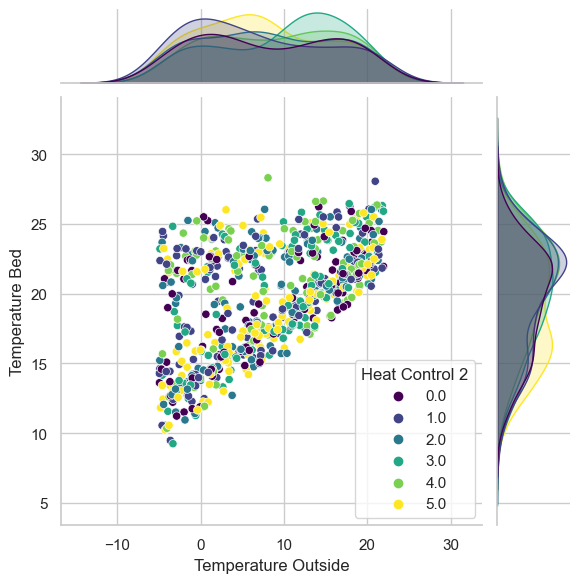

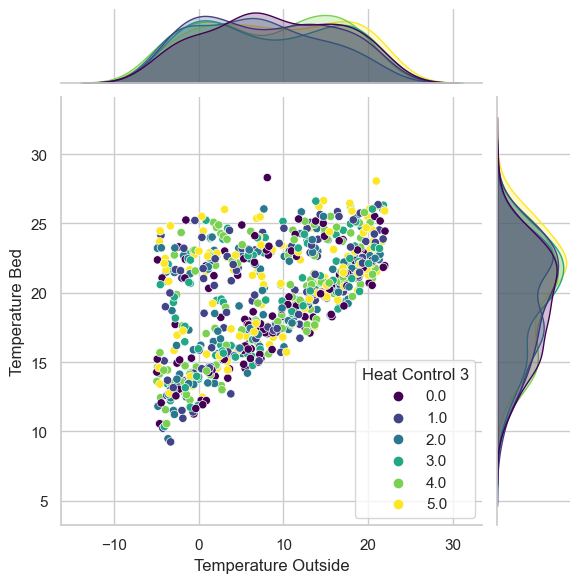

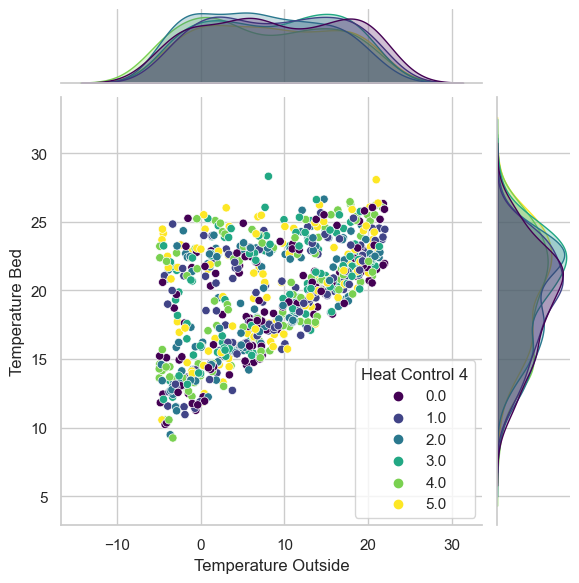

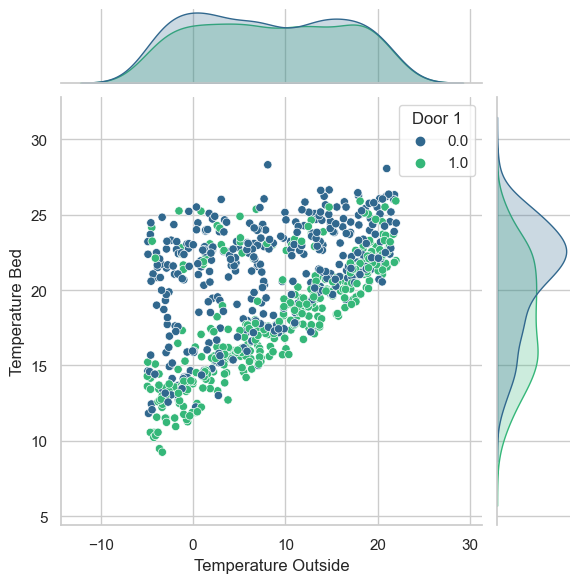

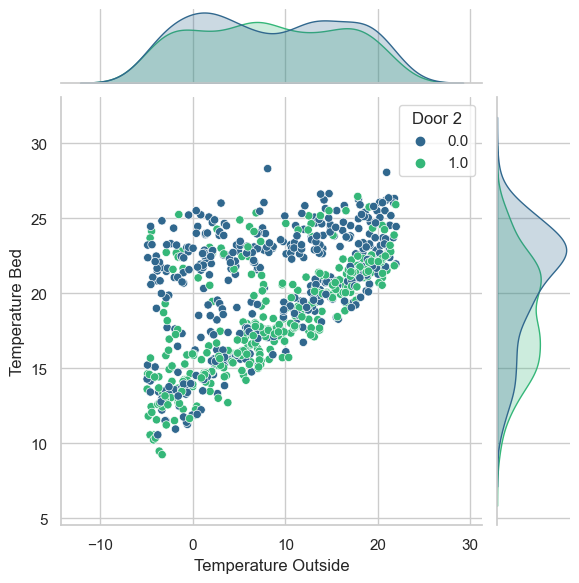

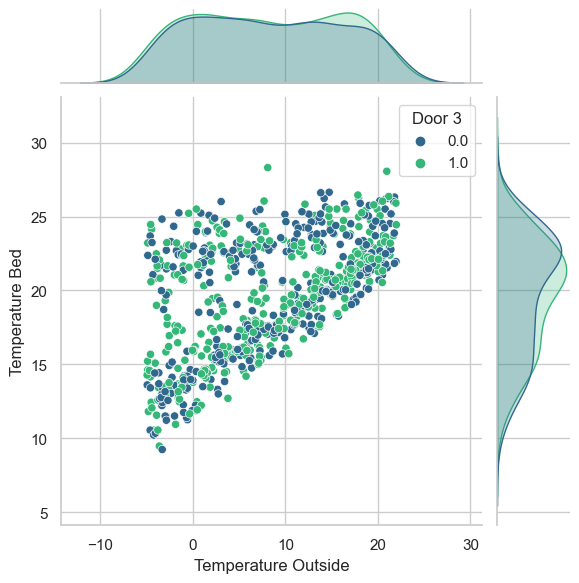

In [86]:
for column in original_df.columns[:-2]:
    sns.jointplot(data = original_df, x = "Temperature Outside", y = "Temperature Bed", hue = column, palette = "viridis")
plt.show()

### Define Regressor

My idea is to interpolate over the data but weigh it according to my observations and domain knowledge. So I give low weights to windows 2 and 3. Same with door 3. Then I also think that the doors are more important for the overall value than the individual heaters. My predictor is now a simple inverse distance weighting interpolation.

In [59]:
class PetersenRegressor:
    
    def __init__(self, p = 4):
        self.p = p
    
    
    def distance(self, x, y):
        return np.linalg.norm(self.weights * (x - y))
    
        
    def predict(self, X):
        if self.weights is None or self.X is None or self.Y is None:
            raise Exception("Not fitted yet!")
                
        prediction = np.zeros(X.shape[0])
        
        for k, row in enumerate(X):
            # index if row is already in fitted data
            index = np.where(np.all(row == self.X, axis = 1))[0]
            
            if index.size == 0:
                # inverse distance weighting
                inverse_distance_weights = np.array([1 / self.distance(row, x)**self.p for x in self.X])
                value = np.sum(self.Y * inverse_distance_weights)
                total_inverse_distance = np.sum(inverse_distance_weights)
                prediction[k] = value / total_inverse_distance
                
            else:
                prediction[k] = self.Y[index[0]]
            
        return prediction
        
        
    def fit(self, X, Y, weights = None):
        if weights is None:
            self.weights = [10, 0.1, 1, 10, 1, 1, 1, 1, 10, 10, 1, 1]
        else:
            self.weights = weights
        self.X = X
        self.Y = Y
        
        
    def score(self, X, Y):
        # root mean squared error
        return np.linalg.norm(self.predict(X) - Y) / np.sqrt(Y.shape[0])
    
    def get_params(self, deep):
        # for compatability with sklearn
        return {}

### Optimize Weights

In [101]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

X = original_df.values[:, :-1]
y = original_df.values[:, -1]

f_reg = SelectKBest(f_regression, k = "all").fit(X, y).scores_
mi_reg = SelectKBest(mutual_info_regression, k = "all").fit(X, y).scores_

scores = pd.DataFrame(index = original_df.columns[:-1])
scores.loc[:, "correlation"] = corr_matrix["Temperature Bed"][:-1]
scores.loc[:, "f_regression"] = f_reg
scores.loc[:, "mutual_info_regression"] = mi_reg

scores

,correlation,f_regression,mutual_info_regression
Window 1,-0.142900,15.175957,0.036565
Window 2,-0.174103,22.756943,0.001135
Window 3,-0.082537,4.993416,0.039174
Window 4,-0.183217,25.286738,0.007279
Heat Control 1,0.223071,38.122674,0.094366
Heat Control 2,-0.013544,0.133564,0.000000
Heat Control 3,0.086538,5.493003,0.002419
Heat Control 4,0.098734,7.166648,0.041398
Door 1,-0.369794,115.322026,0.057446
Door 2,-0.314560,79.944248,0.054873


In [105]:
weights = {
    "ones" : np.ones(12),
    "Petersen" : [10, 1, 1, 10, 1, 1, 1, 1, 10, 10, 1, 1],
    "more Petersen" : [100, 1, 1, 100, 1, 1, 1, 1, 100, 100, 1, 1],
    "even more" : [1000, 1, 1, 1000, 1, 1, 1, 1, 1000, 1000, 1, 1],
    "f score" : f_reg,
    "mutual info" : mi_reg,
    "correlation" : corr_matrix["Temperature Bed"][:-1]
}

rms = pd.DataFrame()

for name, weight in weights.items():
    reg = PetersenRegressor()
    reg.fit(X_train, Y_train, weights = weight)
    rms.loc[name, "RMS"] = reg.score(X_test, Y_test)

rms.style.highlight_min(color = "green")

,RMS
ones,2.997729
Petersen,1.968217
more Petersen,1.852029
even more,1.851989
f score,2.644927
mutual info,3.205690
correlation,2.612863


## Model Selection

We train on 80% of the data and then test on the remaining 20%.

In [60]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(original_df.values, test_size = 0.2, random_state = random_state)

X_train = train[:, :-1]
Y_train = train[:, -1]
X_test = test[:, :-1]
Y_test = test[:, -1]

In [8]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor, Ridge, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Sum, WhiteKernel, DotProduct
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

regressors = {
    "Petersen" :          PetersenRegressor(),
    "Nearest Neighbors" : KNeighborsRegressor(),
    "linear Model" :      LinearRegression(),
    "linear SVM" :        SVR(kernel = "linear"),
    "polynomial SVM":     SVR(kernel = "poly"),
    "radial SVM":         SVR(kernel = "rbf"),
    "Theil-Sen" :         TheilSenRegressor(random_state = random_state),
    "RANSAC" :            RANSACRegressor(random_state = random_state),
    "Ridge" :             Ridge(random_state = random_state),
    "Bayesian Ridge" :    BayesianRidge(),
    "linear Ridge" :      KernelRidge(kernel = "linear"),
    "polynomial Ridge":   KernelRidge(kernel = "poly"),
    "radial Ridge":       KernelRidge(kernel = "rbf"),
    "Gaussian Process" :  GaussianProcessRegressor(kernel = Sum(DotProduct(), WhiteKernel()), random_state = random_state),
    "Decision Tree" :     DecisionTreeRegressor(random_state = random_state),
    "Random Forest" :     RandomForestRegressor(random_state = random_state),
    "Ada Boost" :         AdaBoostRegressor(random_state = random_state),
    "Gradient Boost" :    GradientBoostingRegressor(random_state = random_state),
    "Neural Network" :    MLPRegressor(max_iter = 2000, alpha = 1, random_state = random_state)
}

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error, explained_variance_score

comparison = pd.DataFrame()

for name, reg in regressors.items():
    print(f"{name:17} : ", end="")
    reg.fit(X_train, Y_train)
    print("fitted, ", end="")
    prediction = reg.predict(X_test)
    print("predicted, ", end="")
    comparison.loc[name, "root mean squared"] = mean_squared_error(Y_test, prediction, squared = False)
    comparison.loc[name, "mean absolute"] = mean_absolute_error(Y_test, prediction)
    comparison.loc[name, "max"] = max_error(Y_test, prediction)
    comparison.loc[name, "explained variance"] = explained_variance_score(Y_test, prediction)
    print("scored.")

Petersen          : fitted, predicted, scored.
Nearest Neighbors : fitted, predicted, scored.
linear Model      : fitted, predicted, scored.
linear SVM        : fitted, predicted, scored.
polynomial SVM    : fitted, predicted, scored.
radial SVM        : fitted, predicted, scored.
Theil-Sen         : fitted, predicted, scored.
RANSAC            : fitted, predicted, scored.
Ridge             : fitted, predicted, scored.
Bayesian Ridge    : fitted, predicted, scored.
linear Ridge      : fitted, predicted, scored.
polynomial Ridge  : fitted, predicted, scored.
radial Ridge      : fitted, predicted, scored.
Gaussian Process  : fitted, predicted, scored.
Decision Tree     : fitted, predicted, scored.
Random Forest     : fitted, predicted, scored.
Ada Boost         : fitted, predicted, scored.
Gradient Boost    : fitted, predicted, scored.
Neural Network    : fitted, predicted, scored.


In [10]:
comparison.style.highlight_min(["root mean squared", "mean absolute", "max"], "green").highlight_max("explained variance", "green")

,root mean squared,mean absolute,max,explained variance
Petersen,1.974394,1.473742,6.966961,0.762518
Nearest Neighbors,3.023535,2.549908,7.907050,0.448827
linear Model,2.097024,1.654550,5.898854,0.731928
linear SVM,2.151175,1.651761,6.325103,0.724112
polynomial SVM,3.139452,2.480373,7.367465,0.399296
radial SVM,2.685788,2.057240,8.425278,0.580823
Theil-Sen,2.097831,1.647327,6.181890,0.731728
RANSAC,2.909287,2.308985,7.882212,0.530407
Ridge,2.097573,1.655372,5.889435,0.731793
Bayesian Ridge,2.099230,1.657290,5.867501,0.731385


## Save Prediction

In [11]:
'''data_test_Temperature = pd.read_csv('data_test_Temperature.csv')
prediction = predict(data_test_Temperature)
predicted_Temperatures = prediction.values[:,-1]
    
np.savetxt('PhilippPetersens_Temperature_prediction.csv', predicted_Temperatures, delimiter=',') '''

"data_test_Temperature = pd.read_csv('data_test_Temperature.csv')\nprediction = predict(data_test_Temperature)\npredicted_Temperatures = prediction.values[:,-1]\n    \nnp.savetxt('PhilippPetersens_Temperature_prediction.csv', predicted_Temperatures, delimiter=',') "